In [155]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys

sys.path.append('/kaggle/working/timeseriespack')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# NFL ALL DAY DATASET

In [156]:
from shroomdk import ShroomDK
from prophet import Prophet

sdk = ShroomDK("cb737b6b-1dee-4285-8cb4-b66133128390")

sql = f"""
       WITH combined_play AS
      (SELECT sales.block_timestamp, sales.price, sales.tx_id,sales.buyer,sales.seller, dim.*
      FROM flow.core.ez_nft_sales sales
      JOIN flow.core.dim_allday_metadata dim
      ON sales.nft_id = dim.nft_id
      AND sales.nft_collection = 'A.e4cf4bdc1751c65d.AllDay'
      AND sales.block_timestamp::date >= CURRENT_DATE - INTERVAL '10 month'),


      raw_data AS
      (SELECT block_timestamp, tx_id, price, team, player,series,set_name, play_type, buyer, seller,nft_id, moment_tier,moment_stats_full
     FROM combined_play

       )
       

     SELECT DATE_TRUNC('hour', block_timestamp) AS hours,
     percentile_cont(.1) within group (
     order by
      price
     ) as floor_price_in_usd
 

    FROM raw_data

    WHERE player ='Jalen Ramsey'
    AND moment_tier ='COMMON'
    GROUP BY hours
   """
       
query_result_set = sdk.query(sql)
df= pd.DataFrame(query_result_set.records)

# print(forcast)


## PREPROCESSING

In [157]:
df['hours']=pd.to_datetime(df['hours']).dt.date
df.rename(columns = {'hours':'ds'}, inplace = True)
df.rename(columns = {'floor_price_in_usd':'y'}, inplace = True)
df = df.query('y < 60').copy()
df.sort_values(by=['ds'], inplace = True)
latest_date=df.ds.max()

## TRAINING

In [158]:
m=Prophet()

m.fit(df)

future=m.make_future_dataframe(periods=14)

18:02:37 - cmdstanpy - INFO - Chain [1] start processing
18:02:37 - cmdstanpy - INFO - Chain [1] done processing


## PREDICTION

In [159]:
forcast=m.predict(future)

forcast.sort_values(by=['ds'], inplace = True)

future_rows=forcast[forcast['ds'].dt.date >= latest_date]

# ACTUAL VS FORCASTED PLOT

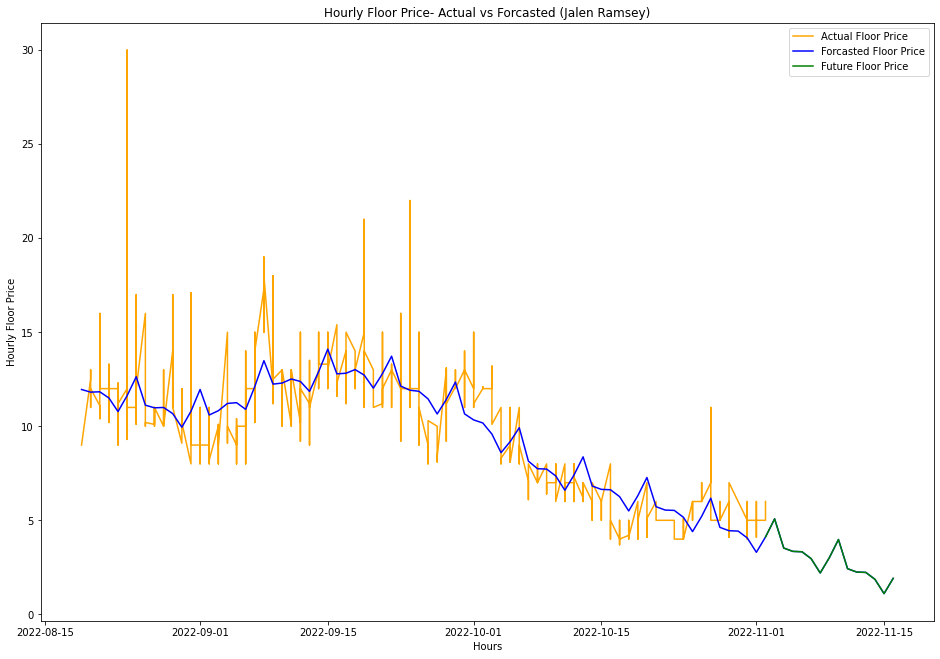

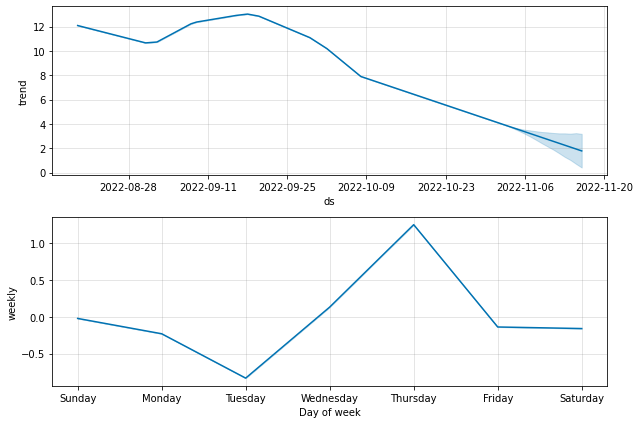

In [160]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(df['ds'], df['y'], color='orange', label='Actual Floor Price')
ax.plot(forcast['ds'], forcast['yhat'], 'b-', label='Forcasted Floor Price')
ax.plot( future_rows['ds'],future_rows['yhat'], color='green', label='Future Floor Price')
ax.set_xlabel('Hours')
ax.set_ylabel('Hourly Floor Price')
ax.set_title('Hourly Floor Price- Actual vs Forcasted (Jalen Ramsey)')


plt.legend()

plt2 = m.plot_components(forcast)